# Hands on timeseries analysis
### part8: Introducing ARIMA 1

<div style="text-align: right"> <b>Author : Kwang Myung Yu</b></div> 

<div style="text-align: right"> Initial upload: 2020.08.19 </div> 
<div style="text-align: right"> Last update: 2020.08.19</div> 

시계열 예측방법인 ARIMA에 대하여 설명한다.
- 참고자료  
    - [Pandas로 하는 시계열 데이터분석](https://tacademy.skplanet.com/live/player/onlineLectureDetail.action?seq=152#sec2)
    - [Time series analysis in Python](https://www.kaggle.com/kashnitsky/topic-9-part-1-time-series-analysis-in-python)
    - [A comprehensive beginner’s guide to create a Time Series Forecast](https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/)

### 1. Why Stationary?

대부분의 시계열 데이터분석 또는 모델링은 데이터가 stationary함을 가정하고 진행된다.  
그런데 자연계 대부분의 데이터는 non-stationary이다.  
시계열을 완벽하게 stationary로 만들수는 없지만 근접하게 만드는 방법이 있다.  
바로 시계열 데이터를 non-stationary로 만드는 주요 요소를 찾아서 제거하는 것이다.

TS를 non stationary로 만드는 두가지 요소  
- Trend : varying mean over time  
- Seasonality : variations at specific time framses  

trend와 seasonality를 추정(estimate)하는 모델을 만들어서 이를 제외 시키고, 나머지, stationary 한 부분만 분석을 실시하면 된다.  
통계 기반 forecasting 기법은 이러한 방법을 사용한다.(나머지 stationary part에 대해서 예측기법을 적용을 한다.)  
그리고 마지막 단계에서 예측한 값에 Trend와 Seasonlity를 적용하여 Original Scale로 돌려 넣는다.

### 2. Making a time seres stationary

`airline passengers.csv` 데이터셋을 사용한다.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
import warnings; warnings.filterwarnings('ignore')
plt.style.use('ggplot')
%matplotlib inline

pd.set_option('display.max_rows', 500)

from sklearn.metrics import mean_squared_error

In [2]:
url = 'https://raw.githubusercontent.com/sguys99/datasets/master/airline_passengers.csv'
df = pd.read_csv(url, index_col='Month', parse_dates=['Month'])

In [3]:
df.head()

,Thousands of Passengers
Month,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


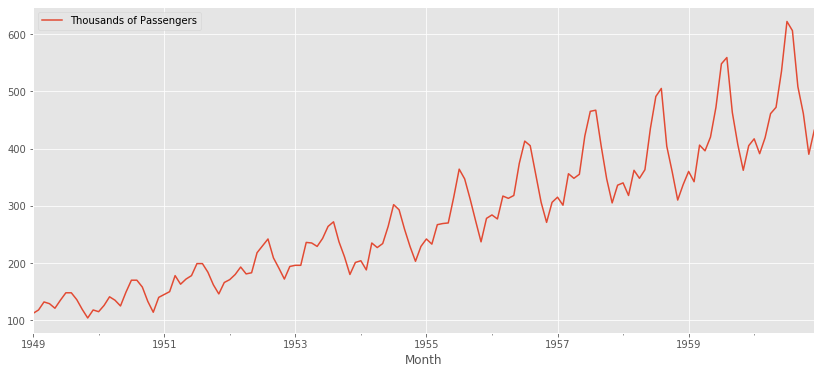

In [4]:
df.plot(figsize = (14, 6))

#### Step 1 : Log transformation

값의 분포를 살펴본다.

(0, 622)

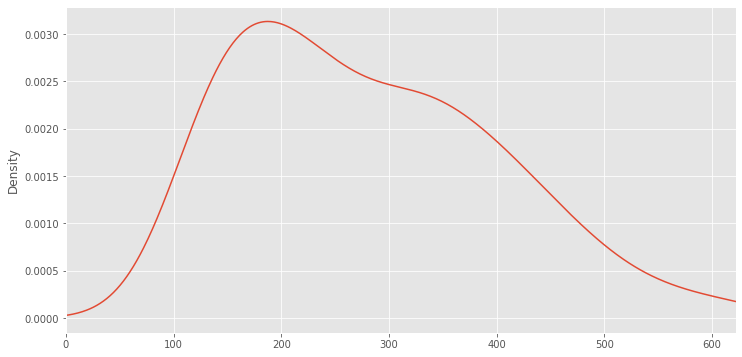

In [5]:
df['Thousands of Passengers'].plot(kind = 'kde', figsize= (12, 6) )
plt.xlim([0, df['Thousands of Passengers'].max()])

trend의 영향을 완화시키기 위해 log를 가해준다.

In [6]:
df['ts_log'] = np.log(df['Thousands of Passengers'])

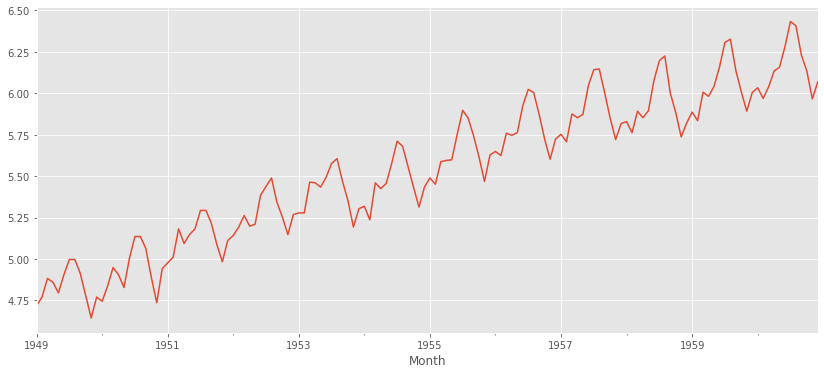

In [7]:
df['ts_log'].plot(figsize = (14, 6))

(4.6443908991413725, 6.432940092739179)

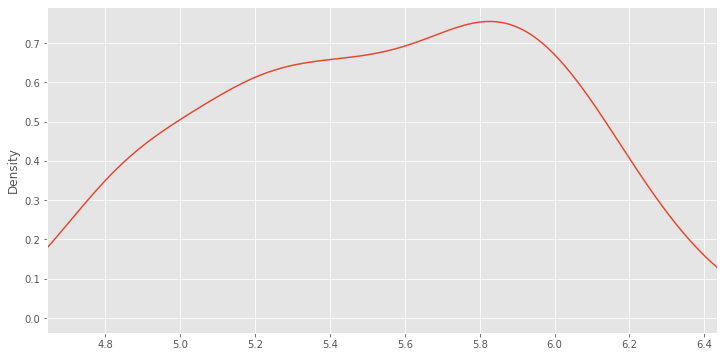

In [8]:
df['ts_log'].plot(kind = 'kde', figsize= (12, 6) )
plt.xlim([df['ts_log'].min(), df['ts_log'].max()])

adf test를 실시하여 데이터가 stationary 해졌는지 확인한다.

In [9]:
from statsmodels.tsa.stattools import adfuller

In [10]:
def test_stationarity(df):
    rolmean = df.rolling(window=12).mean()
    rolstd = df.rolling(window=12).std()
    # 또다른 방법
    # rolmean = pd.rolling_mean(df, window=12)
    
    #시각화
    plt.figure(figsize = (14, 6))
    orig = plt.plot(df, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey-Fuller test
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(df, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    print(' ')
    if dftest[1] <= 0.05:
        print('Stationary : p-value {}'.format(dftest[1]))
    else:
        print('Non-Stationary : p-value {}'.format(dftest[1]))

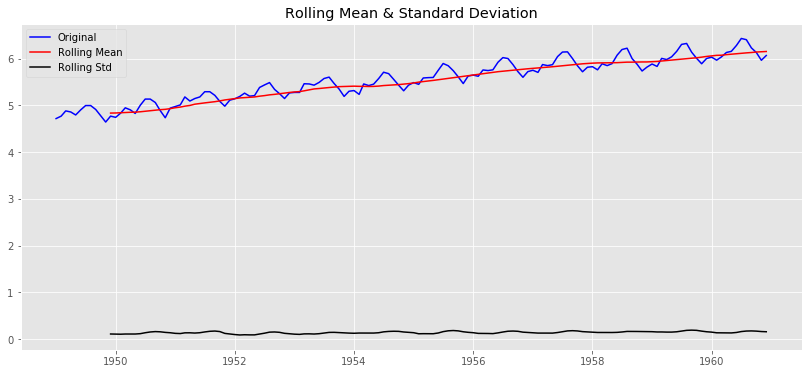

Results of Dickey-Fuller Test:
Test Statistic                  -1.717017
p-value                          0.422367
#Lags Used                      13.000000
Number of Observations Used    130.000000
Critical Value (1%)             -3.481682
Critical Value (5%)             -2.884042
Critical Value (10%)            -2.578770
dtype: float64
 
Non-Stationary : p-value 0.4223667747703888


In [11]:
test_stationarity(df['ts_log'])

- mean 변화가 감소했지만 여전히 trend 성분이 존재한다.

#### Step 2 : First difference

trend와 seasonal 성분 제거를 위해 1차 차분을 실시한다.

In [12]:
df['ts_log_1st_diff'] = df['ts_log'].diff()

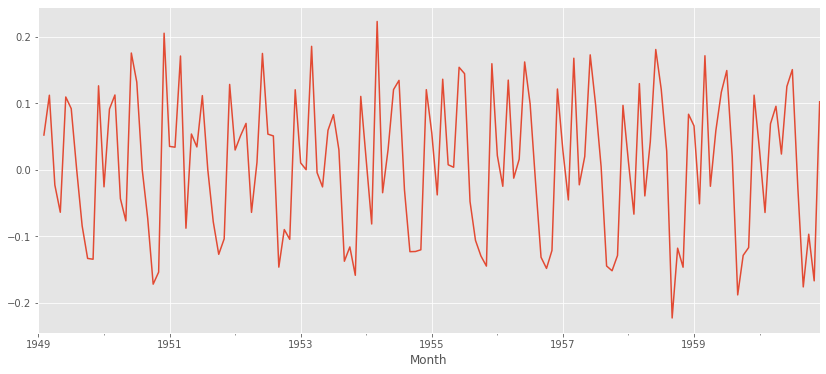

In [13]:
df['ts_log_1st_diff'].plot(figsize = (14, 6))

adf test를 실시

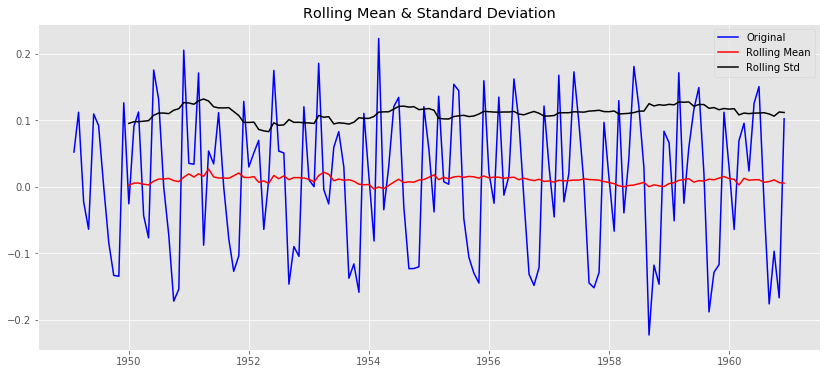

Results of Dickey-Fuller Test:
Test Statistic                  -2.717131
p-value                          0.071121
#Lags Used                      14.000000
Number of Observations Used    128.000000
Critical Value (1%)             -3.482501
Critical Value (5%)             -2.884398
Critical Value (10%)            -2.578960
dtype: float64
 
Non-Stationary : p-value 0.07112054815085295


In [14]:
test_stationarity(df['ts_log_1st_diff'].dropna())

- p-value > 0.05(5%) 이므로 여전히 non-stationary이다. 
- 하지만 Test Statistic < Critical Value(10%)이다. 따라서 90% 신뢰구간에서 차분한 데이터가 stationary로 볼수있다.
- 2차, 3차 차분을 할 수록 더 좋은 결과를 얻을수도 있다.(여기서는 그냥 1차 차분한 결과를 사용한다.)

#### Step 3 : Seasonal difference  

본 데이터의 경우 seasonal 주기가 12개월인 것을 알고 있다.
seasonal difference를 실시하면 stationarity가 커지는지 확인해본다.

In [15]:
df['ts_log_seasonal_1st_diff'] = df['ts_log_1st_diff'].diff(12)

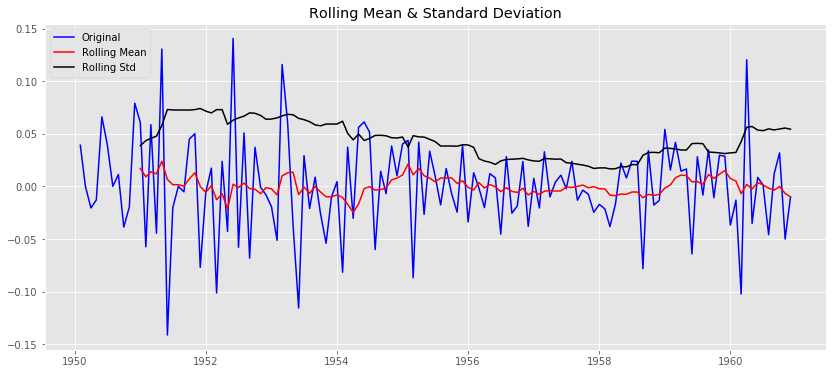

Results of Dickey-Fuller Test:
Test Statistic                  -4.443325
p-value                          0.000249
#Lags Used                      12.000000
Number of Observations Used    118.000000
Critical Value (1%)             -3.487022
Critical Value (5%)             -2.886363
Critical Value (10%)            -2.580009
dtype: float64
 
Stationary : p-value 0.0002485912311383993


In [16]:
test_stationarity(df['ts_log_seasonal_1st_diff'].dropna())

- 예상대로 Stationary 해졌다.  
- 일단 본 예제에서는 `ts_log_1st_diff` 컬럼의 값만 사용한다.

### 3. Introducing ARIMA

#### ARIMA(Auto-Regressive Integrated Moving Averages)

- ARIMA는 시계열 데이터 예측을 위한 선형 방정식이다.  
- ARIMA는 시계열 데이터가 stationary 특성을 보일 때 효과적이다.  
  (앞에서 differencinmg을 수행한 이유가 이 때문이다.)

ARIMA 모델은 다음의 세가지 term으로 구분된다.  
- AR(Auto-Regressive) : t시점의 데이터와 이전시점(t-p)의 데이터를 사용한 회귀모델  
    - $AR = \phi_{0} + \phi_{1} \cdot y_{t-1} + ... + \phi_{p} \cdot y_{t-p} $
- MA(Moving Average) : t시점의 데이터와 이전시점(t-q)의 residual에 대한 모델  
    - $MA = \theta_{0} + \theta_{1} \cdot \epsilon_{t-1} + ... + \theta_{q} \cdot \epsilon_{t-q} $
- I(Integrated) : differencing  
    - $I = y_t - y_{t-d} $
$$ \hat{y}_{t} = constant + AR - MA$$

ARIMA 모델을 설계할 때 p, q, d term을 미리 지정해야 한다.  
($\phi$와 $\theta$는 model을 fit하는 과정에서 구해진다.)

SARIMA(Seasonal ARIMA)를 사용할 경우, Seasonal term에 대한 미지수 P, D, Q, m이 추가된다.  
다시 정리하면
- ARIMA(p, d, q)
- ARIMA(p, d, q)(P, D, Q)m  (여기서 m은 seasonal 주기)

앞에서 우리는 1차 차분을 적용하였으므로 d = 1이다.  
이제 찾아야 할 값은 p, d이다.



#### ACF and PACF (p, q 찾기)

- **Autocorrelation Function (ACF):** 시계열과 시계열 자신의 lagged version과 비교한다. 예를 들어 lag 5의 값은, t_start ~ t_end에서의 데이터와 t_start-5 ~ t_end ~ -5 시점의 데이터를 비교한다.  
- **Partial Autocorrelation Function (PACF):** 마찬가지로 시계열과 시계열의 lagged version을 비교한다. 단 앞의 lag 효과를 제거한 후 비교한다. 예를 들어 lag 5에서 lag 1 ~ 4에 의한 효과를 제거한 후 correlation을 계산한다.

- *ACF는 p 값을 찾을때* 사용되고, *PACF는 q 값을 찾을 때* 사용된다.

`df['ts_log_1st_diff']`에 대한 ACF, PACF 구해보기

In [17]:
from statsmodels.tsa.stattools import acf, pacf

In [18]:
lag_acf = acf(df['ts_log_1st_diff'].dropna())
lag_pacf = pacf(df['ts_log_1st_diff'].dropna())

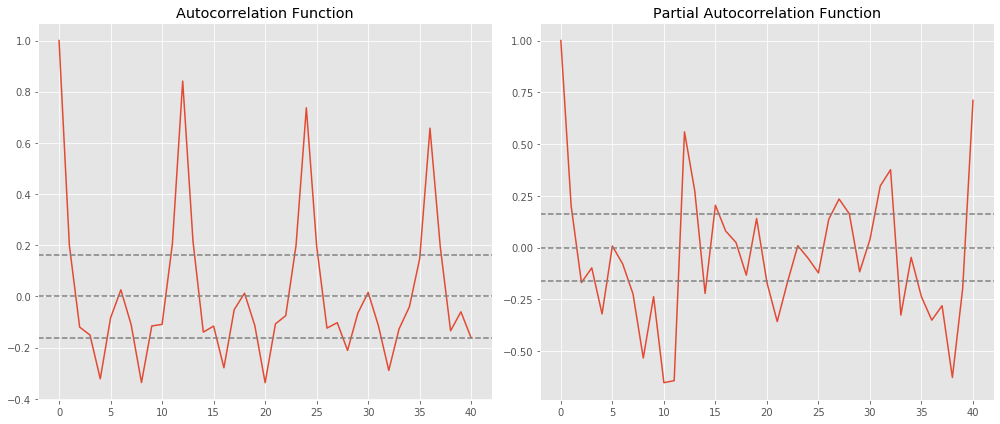

In [19]:
#Plot ACF: 
plt.figure(figsize = (14, 6))
plt.subplot(121) 
plt.plot(lag_acf)
#신뢰구간
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')

#Plot PACF:
plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
#신뢰구간
plt.axhline(y=-1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(df)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

- 0 양쪽의 점선은 신뢰 구간이다. p, q를 결정하는데 사용할 수가 있다.  
- p = 2로 설정한다. PACF에서 lag가 2일 때 최초로 PACF의 상단 신뢰구간을 통과하므로  
- q = 2로 설정한다. ACF에서  lag가 2일 때 최초로 PACF의 상단 신뢰구간을 통과하므로

시각화 함수 만들기  
- 시각화 기능을 강화한 함수를 만든다.

In [20]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller

In [21]:
def tsplot(y, lags=None, figsize=(12, 7), style='bmh'):
    """
        Plot time series, its ACF and PACF, calculate Dickey–Fuller test
        
        y - timeseries
        lags - how many lags to include in ACF, PACF calculation
    """
    if not isinstance(y, pd.Series): #y가 pd.Series에 적합한 인자인지 확인, 
                                     # ex) isinstance(1.2, int) => False가 리턴
        y = pd.Series(y)
        
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        layout = (2, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        
        y.plot(ax=ts_ax)
        dftest = adfuller(y, autolag='AIC')
        if dftest[1] <= 0.05:
            result = 'Stationary'
        else:
            result = 'Non-Stationary'
        ts_ax.set_title('Time Series Analysis Plots\n {0:}: p-value {1:.5f}'.format(result, dftest[1]))
        plot_acf(y, lags=lags, ax=acf_ax)
        plot_pacf(y, lags=lags, ax=pacf_ax, method='ywm')
        plt.tight_layout()

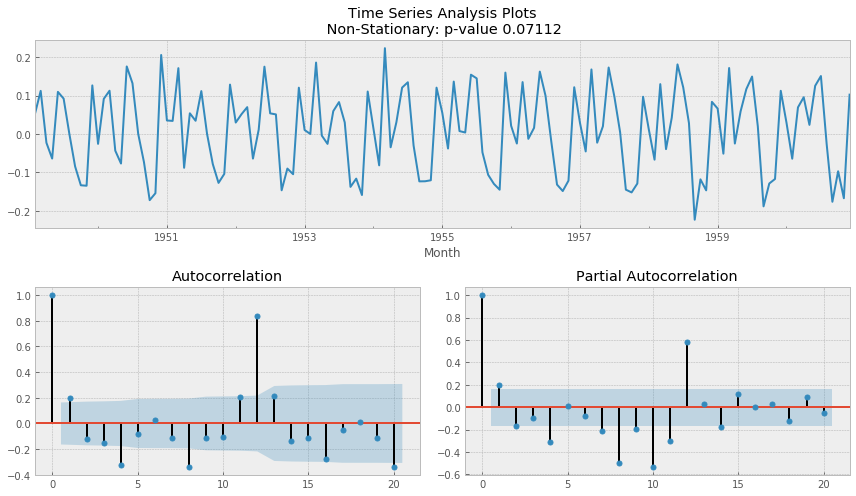

In [22]:
tsplot(df['ts_log_1st_diff'].dropna(), lags = 20)

- 앞에서과 같은 결과를 확인할 수 있다.
- (p, d, q) = (2, 1, 2)로 설정한다.

#### ARIMA 모델 사용하기

In [23]:
from statsmodels.tsa.arima_model import ARIMA

In [24]:
model = ARIMA(df['ts_log'], order=(2, 1, 2))  
results_ARIMA = model.fit()

In [25]:
results_ARIMA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:               D.ts_log   No. Observations:                  143
Model:                 ARIMA(2, 1, 2)   Log Likelihood                 149.640
Method:                       css-mle   S.D. of innovations              0.084
Date:                Wed, 19 Aug 2020   AIC                           -287.281
Time:                        23:39:27   BIC                           -269.504
Sample:                    02-01-1949   HQIC                          -280.057
                         - 12-01-1960                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const              0.0096      0.003      3.697      0.000       0.005       0.015
ar.L1.D.ts_log     1.6293      0.039     41.868      0.000       1.553       1.706
ar.L2.D.ts_log    -0.8946      0.039    -23.127      0.000      -0.970      -0.819
ma.L1.D.ts_log    -1.8270      0.036    -51.303      0.000      -1.897      -1.757
ma.L2.D.ts_log     0.9245      0.036     25.568      0.000       0.854       0.995
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.9106           -0.5372j            1.0573           -0.0848
AR.2            0.9106           +0.5372j            1.0573            0.0848
MA.1            0.9881           -0.3245j            1.0400           -0.0505
MA.2            0.9881           +0.3245j            1.0400            0.0505
-----------------------------------------------------------------------------
"""

차분한 상태에서 실제 값과 fitting 값 비교

Text(0.5, 1.0, 'RSS: 1.0292')

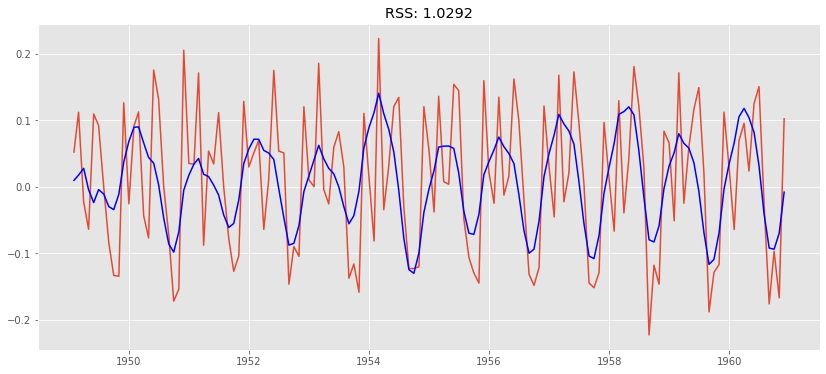

In [26]:
plt.figure(figsize = (14, 6))
plt.plot(df['ts_log_1st_diff'].dropna())
plt.plot(results_ARIMA.fittedvalues, color='b')
plt.title('RSS: %.4f'% sum((results_ARIMA.fittedvalues.values - \
                            df['ts_log_1st_diff'].dropna().values.reshape(-1, ))**2))

#### 원래 스케일(Original Scale)로 복원하기
- `results_ARIMA.fittedvalues` 만으로 원래 스케일 복원해본다.  
- 복원순서(변환 작업의 역순으로) : 차분 해제(누적합 계산) -> base 값 추가 -> log변환 해제(exponential 연산)

예측 결과를 별도의 series로 저장한다.

In [27]:
predictions_ARIMA_diff = pd.Series(results_ARIMA.fittedvalues, copy=True)

In [28]:
predictions_ARIMA_diff.head()

Month
1949-02-01    0.009580
1949-03-01    0.017491
1949-04-01    0.027670
1949-05-01   -0.004521
1949-06-01   -0.023890
dtype: float64

차분을 원래대로 돌리기 위해 누적합을 계산한다.(cummulative sum)

In [29]:
predictions_ARIMA_diff_cumsum = predictions_ARIMA_diff.cumsum()

누적합 결과에 base 값을 더한다.  
df['ts_log']의 첫째날 값을 더하면 된다.

In [30]:
df.iloc[0].ts_log

4.718498871295094

In [31]:
predictions_ARIMA_log = pd.Series(df.iloc[0].ts_log, index=df.index) 
# 첫날 값으로 series 만듬

In [32]:
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.718499
1949-03-01    4.718499
1949-04-01    4.718499
1949-05-01    4.718499
dtype: float64

In [33]:
predictions_ARIMA_log = predictions_ARIMA_log.add(predictions_ARIMA_diff_cumsum,
                                                  fill_value=0)
# base + cumsum()

In [34]:
predictions_ARIMA_log.head()

Month
1949-01-01    4.718499
1949-02-01    4.728079
1949-03-01    4.745570
1949-04-01    4.773241
1949-05-01    4.768720
dtype: float64

log변환을 해제하기 위해 exp함수를 사용한다.

In [35]:
predictions_ARIMA = np.exp(predictions_ARIMA_log)

결과 확인 및 시각화

Text(0.5, 1.0, 'RMSE: 90.1041')

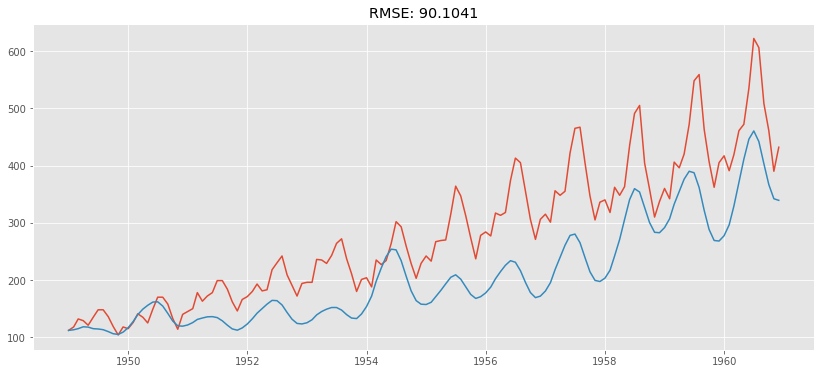

In [36]:
plt.figure(figsize = (14, 6))
plt.plot(df['Thousands of Passengers'])
plt.plot(predictions_ARIMA)
plt.title('RMSE: %.4f'% np.sqrt(sum((predictions_ARIMA.values-df['Thousands of Passengers'].values.reshape(-1,))**2)/len(df)))

### 4. 정리  
- Non-stationary 데이터를 stationary하게 변환하는 방법을 설명하였다.  
- ARIMA의 주요 개념을 소개하였다.  
- 다음장에서는 ARIMA, SARIMA 모델을 사용하여 시계열을 예측하는 방법에 대하여 상세하게 설명한다.